<a href="https://colab.research.google.com/github/jonatanriq/oceanografia/blob/main/plotando_ora5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EGG10083 - Métodos de Análise de Dados em Oceanografia Física

# Acompanhamento e Exercício [Aula 03]
## **Se você está olhando no GitHub, sugiro abrir no colab...**

Aluno: **Jonatan Nascimento**

As ferramentas que serão utilizadas nesse trabalho consistem nos pacotes **ProPlot** e o **PyGMT**. Ambos os pacotes necessitam de metodologia específica para serem instalados no ambiente do Colab.

Essa metodologia será descrita ao longo do trabalho para facilitar a compreensão do notebook.


---



Primeiro, é necessário configurar o Colab pra receber o pacote do Proplot. O código abaixo serve para excluir e recolocar o cartopy e o shapely, de forma a rodarem no ambiente colab sem se conflitarem.

## Antes de tudo

O *porquê* de fazer isso você vai saber mais tarde...

In [ ]:
!sudo apt-get install python3-pip python3-tk libudunits2-dev libproj-dev proj-bin libgeos-dev libcunit1-dev

In [ ]:
!pip3 install scitools-iris

In [ ]:
!pip install --upgrade numpy

     |████████████████████████████████| 15.7 MB 8.7 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


**NÃO ESQUEÇA DE DAR "RESTART RUNTIME". NÃO FUNCIONA SEM ISSO.**

In [ ]:
!pip install iris-sample-data

## 1. Instalando o ProPlot

In [ ]:
%%capture
# Nessa primeira etapa, o código atualiza os pacotes contidos na máquina.
!grep '^deb ' /etc/apt/sources.list | \
  sed 's/^deb /deb-src /g' | \
  tee /etc/apt/sources.list.d/deb-src.list
!apt-get update

# Instalando o cartopy e removendo o shapely
!apt-get -qq build-dep python3-cartopy
!apt-get -qq remove python-shapely python3-shapely

# Reinstalando o shapely e o cartopy, nas versões adequadas
!pip install --no-binary shapely shapely --force

!pip install --no-binary cartopy cartopy==0.17.0
# Instalando o ProPlot
!pip install proplot

Demora um pouco... 

## 2. Acessando a conta do Copernicus. 



In [ ]:
###### change the data to your own key ######
!echo url: https://cds.climate.copernicus.eu/api/v2 > ~/.cdsapirc
!echo key: 107775:c0e6435b-3d50-44c7-9bd8-b17b795f0fc6 >> ~/.cdsapirc
!echo verify:0 >> ~/.cdsapirc
# verificando...
!more ~/.cdsapirc

url: https://cds.climate.copernicus.eu/api/v2
key: 107775:c0e6435b-3d50-44c7-9bd8-b17b795f0fc6
verify:0


Agora, é necesário instalar o cliente do CDS API. Utiliza-se o comando pip pra isso.

In [ ]:
# Instalando a API do CDS
%%capture
!pip install cdsapi

Esse é um pouco mais rapido...

##3. Extraindo os dados do Copernicus!

1.   Abrir o cliente CDS
2.   Passar os parâmetros do dado ao Copernicus
3.   Extrair o Arquivo (.nc ou .zip)
4.   Plotando o dado



###Etapa 1:

Vamos usar o cliente CDS API...

In [ ]:
# and finally, import your client to download ERA5
# Run this command in any environment, regardless of whether it's COLAB or Jupyter
# if everything worked out, you can already work with the CDS api.
import cdsapi
cds = cdsapi.Client()

In [ ]:
# só pra não aparecer os avisos no output. São chatos...
import warnings
warnings.filterwarnings("ignore")

### Etapa 2:

Passando os parâmetros do dado...

*Spoiler: Aqui vai ter um probleminha...*

Pro script rodar completamente, coloquei essa parte em forma de comentário.

Pra tirar os comentários, dê **'ctrl' + 'shift' + '/'** ou **'command' + 'shift' + '/'**, se estiver no *macOS*)

In [ ]:
# import cdsapi
# import xarray as xr
# from urllib.request import urlopen
# # iniciando o cliente
# cds = cdsapi.Client()
# # nome do dataset que eu quero ler - poderia colocar direto lá
# dataset = "reanalysis-oras5"

# # flag to download data {não entendi muito bem}
# download_flag = False

# # os parâmetros para o dado 
# params = {
#     'format': 'netcdf',
#     'product_type': 'consolidated',
#     'vertical_resolution': 'single_level',
#     'variable': ['sea_surface_salinity', 'sea_surface_temperature'],
#     'year': ['2014'],
#     'month': ['01', '02', '03','04', '05', '06','07', '08', '09','10', '11', '12'],
#     'grid': [1.0, 1.0], # definindo o intervalo do grid
#     'area': [90, -180, -90, 180], # definindo a área de interesse do dado 
#         }

# # pedindo o caminho de pasta para o dado
# fl = cds.retrieve(dataset, params)
# # baixando o dado em si
# if download_flag:
#     fl.download("./output.nc") ## note you are poiting directly to the output.nc file
# # carregando na memória
# with urlopen(fl.location) as f:
#     dset = xr.open_dataset(f.read())

<p align="left">
<img src="https://i.giphy.com/media/Wq4XuPC9gFzR6/200.gif" >

Esse dado especificamente não permite o retorno em NetCdf, então é necessário usar outra metodologia de extração do dado ORAS5 do Copernicus...


###Etapa 3:

Resolvendo o probleminha - Metodologia de extração em Zip...

Primeiro, vamos passar os mesmos parâmetros pro Copernicus e pedir o download

In [ ]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-oras5',
    {
        'format': 'zip',
        'product_type': 'consolidated',
        'vertical_resolution': 'single_level',
        'variable': [
            'sea_surface_salinity', 'sea_surface_temperature',
        ],
        'year': ['2014'],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
    },
    'download.zip')

2021-12-08 00:46:15,657 INFO Welcome to the CDS
2021-12-08 00:46:15,659 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-oras5
2021-12-08 00:46:15,937 INFO Request is completed
2021-12-08 00:46:15,939 INFO Downloading https://download-0001.copernicus-climate.eu/cache-compute-0001/cache/data0/dataset-reanalysis-oras5-c922b5d7-b99e-4728-b87f-883391ff99e7.zip to download.zip (155M)
2021-12-08 00:47:35,098 INFO Download rate 2M/s


Result(content_length=162576963,content_type=application/zip,location=https://download-0001.copernicus-climate.eu/cache-compute-0001/cache/data0/dataset-reanalysis-oras5-c922b5d7-b99e-4728-b87f-883391ff99e7.zip)

Agora, precisamos abrir esse dado baixado

In [ ]:
!unzip download.zip

Archive:  download.zip
  inflating: sosstsst_control_monthly_highres_2D_201405_CONS_v0.1.nc  
  inflating: sosaline_control_monthly_highres_2D_201406_CONS_v0.1.nc  
  inflating: sosstsst_control_monthly_highres_2D_201404_CONS_v0.1.nc  
  inflating: sosaline_control_monthly_highres_2D_201407_CONS_v0.1.nc  
  inflating: sosstsst_control_monthly_highres_2D_201411_CONS_v0.1.nc  
  inflating: sosstsst_control_monthly_highres_2D_201406_CONS_v0.1.nc  
  inflating: sosaline_control_monthly_highres_2D_201409_CONS_v0.1.nc  
  inflating: sosaline_control_monthly_highres_2D_201402_CONS_v0.1.nc  
  inflating: sosaline_control_monthly_highres_2D_201408_CONS_v0.1.nc  
  inflating: sosaline_control_monthly_highres_2D_201401_CONS_v0.1.nc  
  inflating: sosaline_control_monthly_highres_2D_201412_CONS_v0.1.nc  
  inflating: sosaline_control_monthly_highres_2D_201411_CONS_v0.1.nc  
  inflating: sosaline_control_monthly_highres_2D_201404_CONS_v0.1.nc  
  inflating: sosaline_control_monthly_highres_2D_20141

<p align="center">
<img width="300" height="200" src="https://images.assetsdelivery.com/compings_v2/profshop/profshop1611/profshop161100030.jpg" >

Bom, parece que os dados ao serem *unzipados* formaram vários nc's, um para cada mês. Pra trabalhar com esse dataset que eu pedi pro copernicus, é melhor unir todos esses datasets em um único. 

Vou usar o método *mfdataset* do Xarray, que permite unir vários datasets em um único.

In [ ]:
# criando a lista de dados com os nomes dos dataframes
dados = []
for i in ['01','02','03','04','05','06','07','08','09','10','11','12']:
  dados.append(f'sosaline_control_monthly_highres_2D_2014{i}_CONS_v0.1.nc')
  dados.append(f'sosstsst_control_monthly_highres_2D_2014{i}_CONS_v0.1.nc')

In [ ]:
# passando os nomes pra abrir em um único dataset
import xarray as xr
dset = xr.open_mfdataset(dados)

**Verificando se foi...**

In [ ]:
dset

<xarray.Dataset>
Dimensions:       (time_counter: 12, x: 1442, y: 1021)
Coordinates:
    nav_lat       (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2014-01-16 ... 2014-12-16
Dimensions without coordinates: x, y
Data variables:
    sosaline      (time_counter, y, x) float32 dask.array<chunksize=(1, 1021, 1442), meta=np.ndarray>
    sosstsst      (time_counter, y, x) float32 dask.array<chunksize=(1, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.4
    NCO:          netCDF Operators version 4.9.2 (Homepage = http://nco.sf.ne...
    title:        Monthly mean 2D Sea Surface fields
    source:       ORAS5 - backward extension (ECMWF)
    institution:  European Centre for Medium-Range Weather Forecasts (ECMWF) ...
    reference:    https://www.ecmwf.int/en/research/climate-reanalysis/ocean-...

<p align="left">
F U N C I O N O U !
<p align= "left">
<img src="https://thumbs.gfycat.com/AggressiveWebbedCormorant-max-1mb.gif"  height=200>



Clássica dança de Carlton Banks em um Maluco no Pedaço. Lembra? 

Sabia que ele já participou de um Comercial com **Michael Jackson**? [Pepsi Generation](https://www.youtube.com/watch?v=po0jY4WvCIc)

Sim. Ele é a criança no casaco vermelho!




###Etapa 4:

Agora, vamos fazer um plot simples do dado
 
 O intuito é verificar a integridade do dado de salinidade. Se tá direitinho ou não.

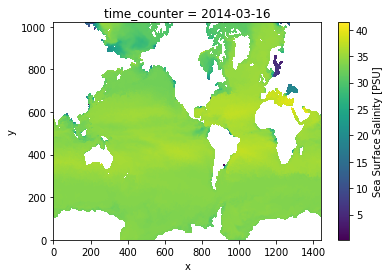

In [ ]:
dset.sel(time_counter='2014-03').sosaline[-1,:,:].plot()

**Parece que sim!**

 Mas esse plot ta beeeem simples. Temos outras opções se utilizarmos os pacotes ProPlot e PyGMT. Vamos melhorar esse gráfico então.

Executando alguns Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.dates as mdates
import seaborn as sns

##4. Instalando o PyGMT

In [ ]:
# because I like to enjoy my coffee in silence (3 runs averaged 8 minutes to install everything ! keep drinking your coffee)
%%capture
!sudo apt update 
!sudo apt upgrade -y
!sudo apt install -y build-essential cmake libcurl4-gnutls-dev libnetcdf-dev gdal-bin libgdal-dev libfftw3-dev libpcre3-dev liblapack-dev libblas-dev libglib2.0-dev ghostscript ghostscript-x graphicsmagick ffmpeg xdg-utils
# clone gmt from source
!git clone --depth 50 https://github.com/GenericMappingTools/gmt
# cmake everything
!cmake /content/gmt
# build and install
!cmake --build . --target install

In [ ]:
# instalando o pygmt através do pip
%%capture
!pip install pygmt

**PyGMT instalado!**

##5. Plotando os dados usando o ProPlot

###Plotando o ORAS5

In [ ]:
saline = dset.sosaline

In [ ]:
saline = saline.isel(time_counter=0) # peguei apenas um tempo já que é um mapa

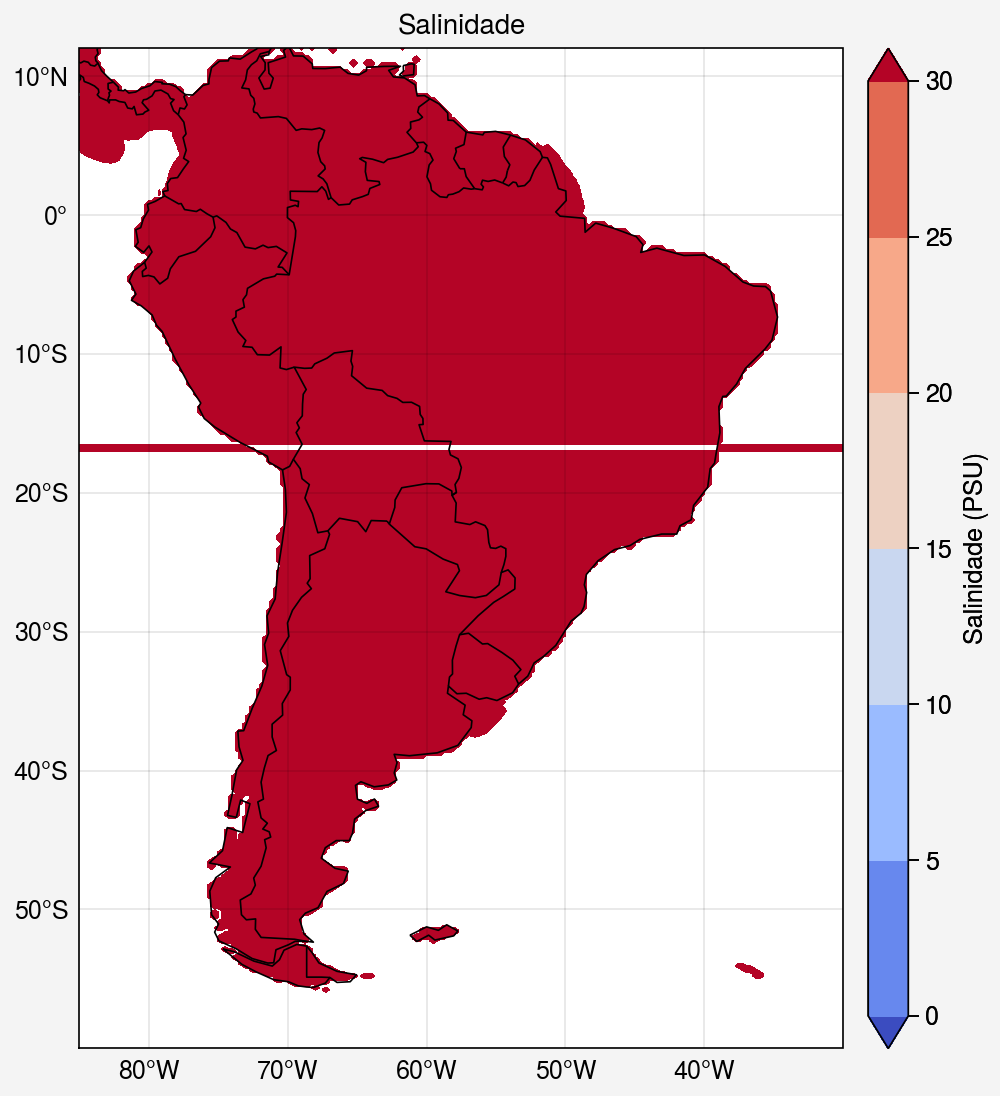

In [ ]:
import proplot as plot # import o proplot
fig, ax = plot.subplots(axheight=5, tight=True,
                         proj='pcarree',) # crio o subplot, e o eixo x tenha 5 de tamanho, e a projeção é plate carree

# plot ta autoexplicativo
ax.format(coast=True, borders=True, innerborders=False,
          labels=True, latlines=10, lonlines=10, 
          latlim=(12, -60), lonlim=(275, 330),
          title='Salinidade') 

# mapa de contorno preenchido
map1 = ax.contourf(saline['nav_lon'], saline['nav_lat'],saline,
                   cmap='coolwarm', levels=plot.arange(0, 30, 5),
                   extend='both')

fig.colorbar(map1, loc='r', label='Salinidade (PSU)')
plot.show()

<p align='left'>
<img src="https://saibacomprar.com.br/wp-content/uploads/2015/12/nojo-jack-sparrow-gif-levitando.gif" height=120 >

ERRGH... Ficou péssimo. Mas por que o plot saiu assim?

O problema está na projeção da base de dados. Os dados do modelo ORAS5 usam projeção *tripolar grid* e a projeção utilizada pra fazer o mapa é PlateCarree. Ou seja, você ta usando duas projeções diferentes pra plotar um mapa.

**Logo, você precisa reprojetar os dados do ORAS5 para platecarree!** 

Felizmente, [foi desenvolvida uma solução pra isso](https://scitools-iris.readthedocs.io/en/stable/generated/gallery/oceanography/plot_orca_projection.html?highlight=tri-polar), usando o IRIS.

### Plotando o ORAS5 (2.0)
Agora vou te contar o porquê daquelas linhas de cógido do início...

Então, você lembra a primeira coisa que rodou no código? Láááá no início?

Pois é, lá foi instalado o **IRIS**

Então agora você ta pronto pra plotar esses dados do ORAS5 direitinho.

```
!sudo apt-get install python3-pip python3-tk libudunits2-dev libproj-dev proj-bin libgeos-dev libcunit1-dev

!pip3 install scitools-iris

!pip install --upgrade numpy

!pip install iris-sample-data
```
---


Importante ressaltar que nesse caso, **parece** que o IRIS não causou problemas ao PyGMT ou ProPlot. Mas é preciso ficar ciente de que ele mexe nas versões do numpy, cartopy e entre outros pacotes. Isso pode causar conflito em um momento ou outro.


In [ ]:
# Executando os imports necessários
import iris
import iris.analysis.cartography
import iris.plot as iplt
import iris.quickplot as qplt

In [ ]:
# carregando o dataset
cube = iris.load_cube('sosaline_control_monthly_highres_2D_201401_CONS_v0.1.nc')

Preciso retirar a parte do dataset que contém time. Isso serve pro dado ficar com a quantidade de dimensões correta pra ser plotado. No IRIS eu só aplico um slicing retirando o primeiro item - **lembrando que em python o primeiro indice é sempre 0**

In [ ]:
cube[0]

<iris 'Cube' of Sea Surface Salinity / (unknown) (-- : 1021; -- : 1442)>

Agora eu reprojeto o dataset para Platecarre...

In [ ]:
# vou usar a ajuda do cartopy
import cartopy.crs as ccrs
new_cube, extent = iris.analysis.cartography.project(cube[0], ccrs.PlateCarree(), nx=1442, ny=1021)

Ploto o dataset pra ver se funcionou a projeção do IRIS...

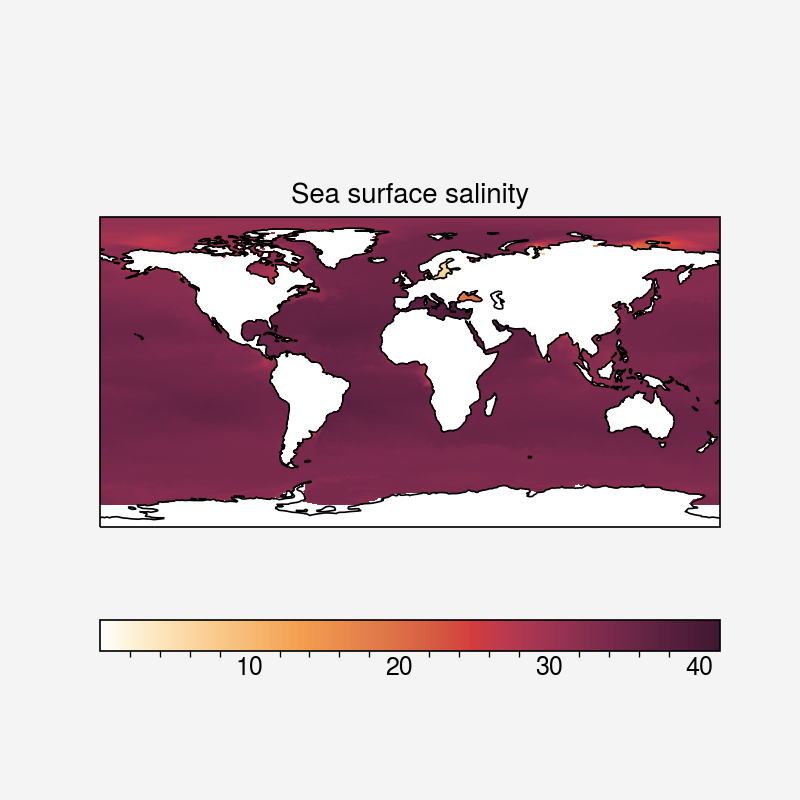

In [ ]:
fig = plt.figure()
# Set up axes and title
ax = plt.subplot(projection=ccrs.PlateCarree())
# Set limits
ax.set_global()
# plot with Iris quickplot pcolormesh
qplt.pcolormesh(new_cube)
# Draw coastlines
ax.coastlines()
iplt.show()

**SIM! FUNCIONOU**

Agora, preciso combinar esse plot do IRIS com os plots que o ProPlot e o PyGMT fornecem. Pra isso, vou combinar a outra plotagem do ProPlot com o contourf do IRIS.


---


NOTA: *O IRIS usa o Matplotlib, então os kwargs pro contourf são iguais. Ou seja, posso passar os mesmos parâmetros que tem no matplotlib.*

### Plotando os dados de Salinidade pelo ProPlot

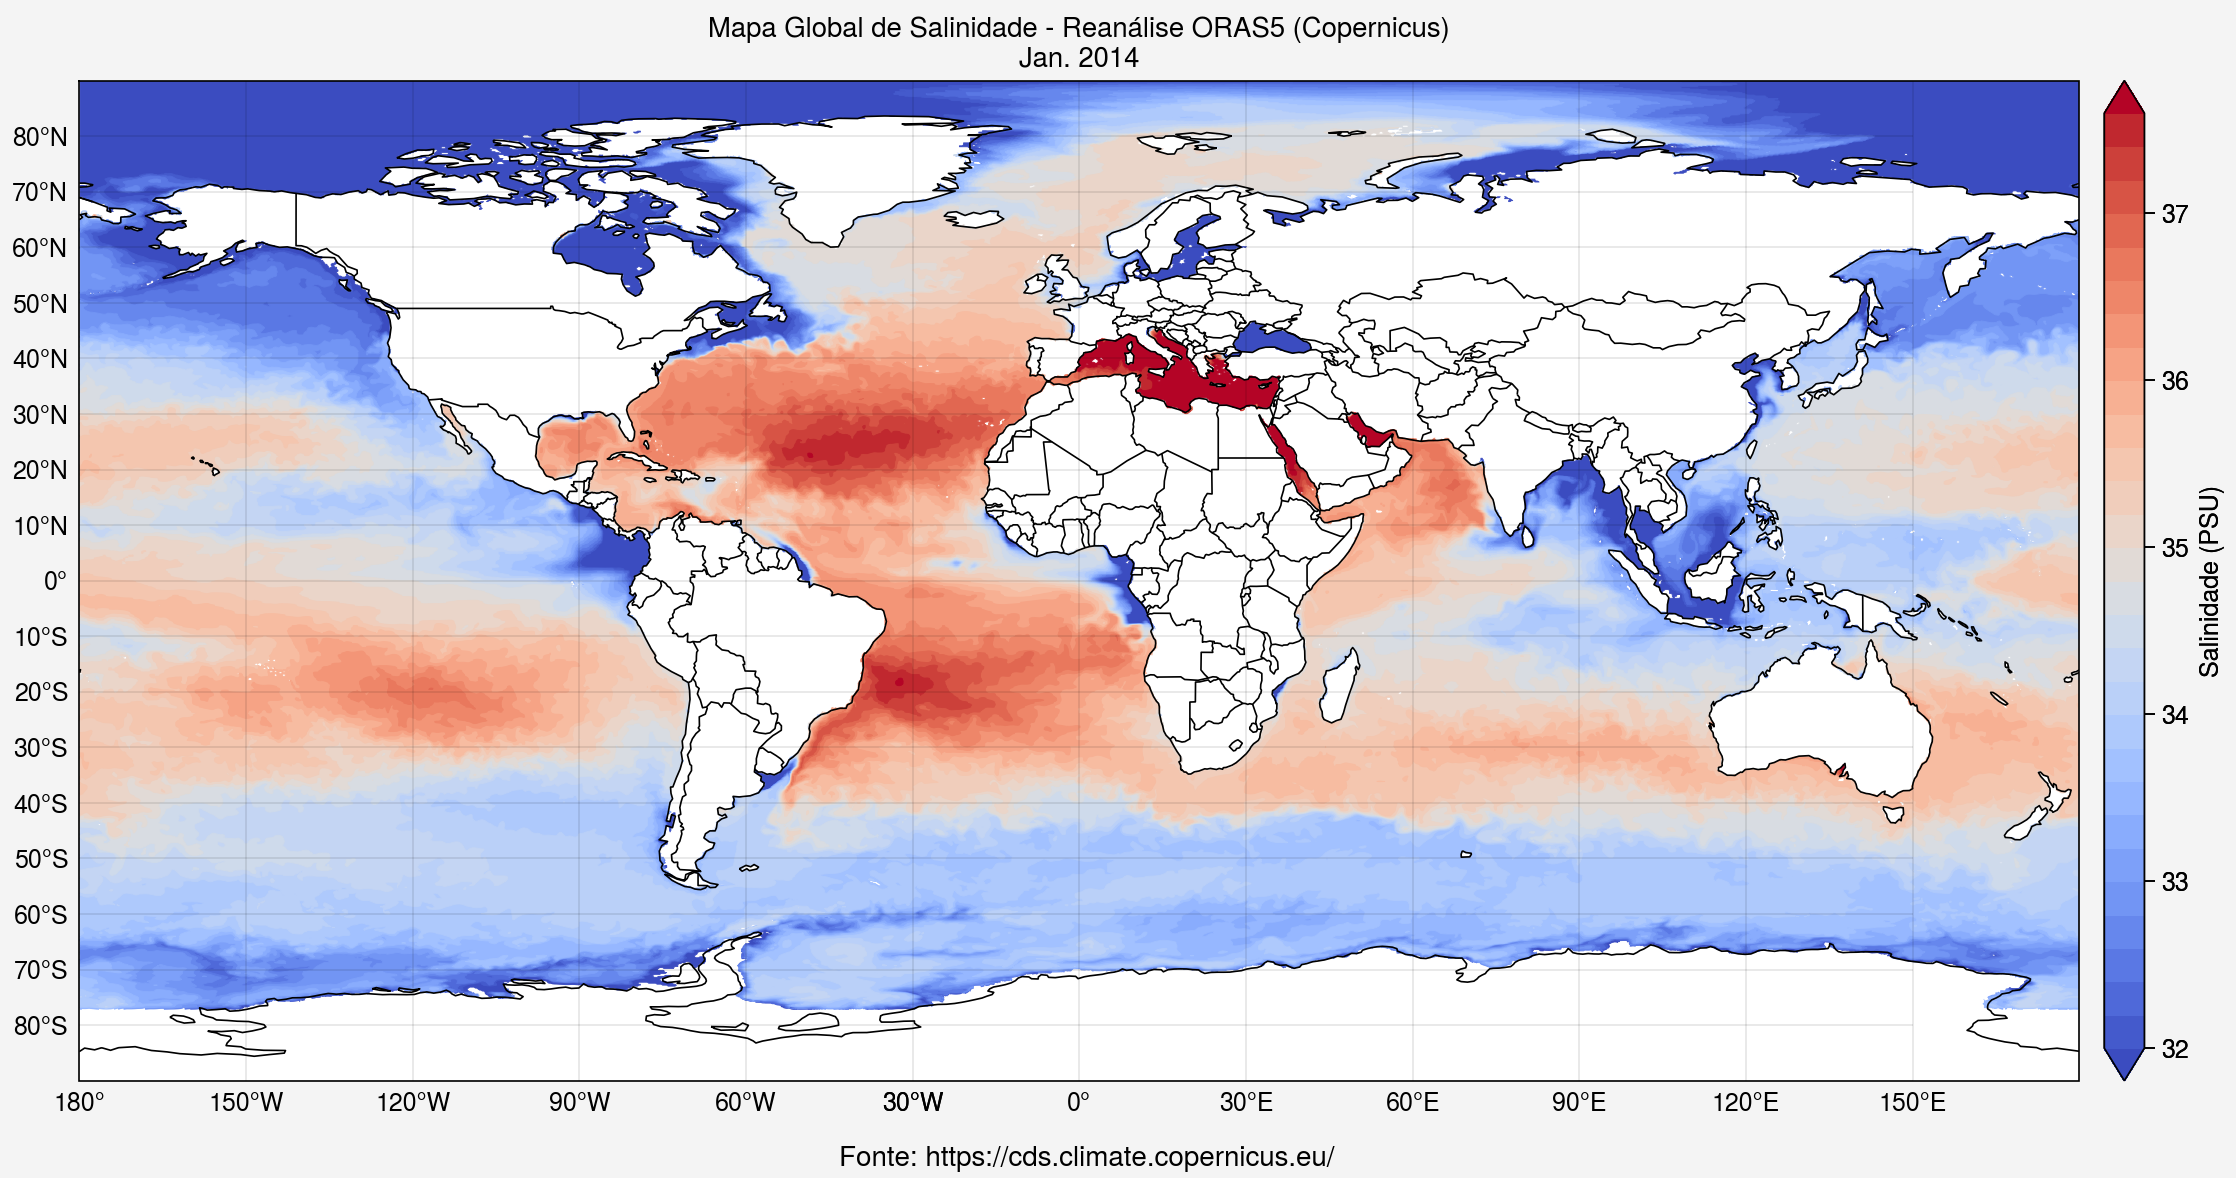

In [ ]:
import proplot as plot # import o proplot
from matplotlib import ticker

fig, ax = plot.subplots(axheight=5, tight=True,
                         proj='pcarree',) # crio o subplot, e o eixo x tenha 5 de tamanho, e a projeção é plate carree

# plot
ax.format(coast=True, borders=True, innerborders=False,
          labels=True, latlines=10, lonlines=30, # definindo o grid de coordenadas
          latlim=(90, -90), lonlim=(0, 360), # definindo os limites do mapa
          title='Mapa Global de Salinidade - Reanálise ORAS5 (Copernicus)\nJan. 2014') 

# mapa de contorno preenchido
map1 = iris.plot.contourf(new_cube, levels=plot.arange(32, 37.6, 0.2),extend='both',cmap='coolwarm') 

plt.text(0.3750, 0.01, 'Fonte: https://cds.climate.copernicus.eu/', fontsize=10, transform=plt.gcf().transFigure)
cb = fig.colorbar(map1, loc='r', label='Salinidade (PSU)')
tick_locator = ticker.MaxNLocator(nbins=6)
cb.locator = tick_locator
cb.update_ticks()
plot.show()

**ÓTIMO!** 

Parece que funcionou o plot. Agora temos um mapa global de salinidade! 

##6. Acessando os pontos das Boias PIRATA



### Vou instalar uma barra de progresso...

O tqdm é uma Barra de Progresso, vou instalar ele pra verificar o progresso da iteração que vou realizar mais a frente.

In [ ]:
!pip install tqdm

In [ ]:
from tqdm.notebook import tqdm

###Visualizando os pontos da Boia Pirata - PyGMT

1.   É necessário adicionar o mapa base. Nesse caso foi usado o mapa base do PanGeo, com 20m de resolução e  projeção *General Perspective*. 
2.  Precisa criar uma lista de links com os dados do PIRATA pra pegar a **lat** e **lon** de cada uma boia e plotar
3. Como cada boia precisa ser plotada individualmente no mapa base, foi feito um loop iterando cada objeto da lista de links. Dentro dessa iteração foi inserida a plotagem das coordenadas da boia



---

O ponto escolhido para trabalhar a boia PIRATA está localizado nas Coordenadas: **8s 38w**

In [ ]:
import pygmt
# criando o plot do PanGeo
fig = plt.figure(figsize=(6,6))
fig = pygmt.Figure()
fig.basemap(region='g', projection='G330/355/12c', frame=True) # frame da Terra ajustado pra região que eu quero
fig.grdimage('@earth_relief_20m', cmap='geo', shading=True) # usei a imagem de batimetria e terreno
fig.coast(resolution='c', shorelines=True, area_thresh=1000) # desenhei as linhas de costa

lista_de_links = ['http://goosbrasil.org:8080/pirata/B0n0e.nc',
                  'http://goosbrasil.org:8080/pirata/B0n10w.nc',
                  'http://goosbrasil.org:8080/pirata/B0n23w.nc',
                  'http://goosbrasil.org:8080/pirata/B0n35w.nc',
                  'http://goosbrasil.org:8080/pirata/B2n10w.nc',
                  'http://goosbrasil.org:8080/pirata/B2s10w.nc',
                  'http://goosbrasil.org:8080/pirata/B4n23w.nc',
                  'http://goosbrasil.org:8080/pirata/B4n38w.nc',
                  'http://goosbrasil.org:8080/pirata/B5s10w.nc',
                  'http://goosbrasil.org:8080/pirata/B6s8e.nc',
                  'http://goosbrasil.org:8080/pirata/B6s10w.nc',
                  'http://goosbrasil.org:8080/pirata/B8n38w.nc',
                  'http://goosbrasil.org:8080/pirata/B8s30w.nc',
                  'http://goosbrasil.org:8080/pirata/B10s10w.nc',
                  'http://goosbrasil.org:8080/pirata/B12n23w.nc',
                  'http://goosbrasil.org:8080/pirata/B12n38w.nc',
                  'http://goosbrasil.org:8080/pirata/B14s32w.nc',
                  'http://goosbrasil.org:8080/pirata/B15n38w.nc',
                  'http://goosbrasil.org:8080/pirata/B19s34w.nc',
                  'http://goosbrasil.org:8080/pirata/B20n38w.nc',
                  'http://goosbrasil.org:8080/pirata/B21n23w.nc']

with tqdm(total=len(lista_de_links)) as pbar:
          for i, j in enumerate(lista_de_links):
            boia_pirata = xr.open_dataset(j)
            boia_pirata = boia_pirata[['latitude','longitude']]
            boia_pirata = boia_pirata.where(boia_pirata.latitude > -90, other = np.nan, drop=0)
            boia_pirata = boia_pirata.where(boia_pirata.latitude < 90, other = np.nan, drop=0)
            boia_pirata = boia_pirata.where(boia_pirata.longitude > 0, other = np.nan, drop=0)
            boia_pirata = boia_pirata.where(boia_pirata.longitude < 360, other = np.nan, drop=0)
            dflat = boia_pirata.latitude.mean()
            dflon = boia_pirata.longitude.mean()
            if j == 'http://goosbrasil.org:8080/pirata/B8s30w.nc':
              fig.plot(dflon,dflat,style="c0.20c", color="red", pen="black")
              fig.text(text="Boia Selecionada", x=dflon, y=dflat+3,font="10p,Helvetica-Bold,white")
            else:
              fig.plot(dflon,dflat,style="c0.20c", color="white", pen="black")
            pbar.update(1)

fig.show()

##7. Comparando os dados de salinidade do ORAS5 com os dados da Boia PIRATA!

Como escolhi a salinidade, Vou comparar os dados de salinidade do Copernicus com os dados de salinidade observados na boia.

**ISSO EM SUPERFÍCIE!**

###Só pra não ter nenhum problema, vou projetar novamente os dados do Copernicus pra PlateCarre

In [ ]:
new_cube, extent = iris.analysis.cartography.project(cube[0], ccrs.PlateCarree(), nx=1442, ny=1021)

###Agora sim, vamos plotar a imagem!

Vou criar uma função onde posso definir o tamanho do mapa que eu quero.

In [ ]:
def mapa(x1,x2,y1,y2,latlines):
  import proplot as plot # import o proplot
  fig, ax = plot.subplots(axheight=5, tight=True,proj='pcarree',) # crio o subplot, e o eixo x tenha 5 de tamanho, e a projeção é plate carree

  # plot
  ax.format(coast=True, borders=True, innerborders=False,
            labels=True, latlines=latlines, lonlines=latlines*1.5, 
            latlim=(x1, x2), lonlim=(y1, y2),
            title='Mapa de Salinidade - Reanálise ORAS5 (Copernicus)\nJan. 2014')  

  # mapa de contorno preenchido
  map1 = iris.plot.contourf(new_cube, levels=plot.arange(32, 37.6, 0.2),extend='both',cmap='coolwarm')

  
  lista_de_links = ['http://goosbrasil.org:8080/pirata/B0n0e.nc',
                    'http://goosbrasil.org:8080/pirata/B0n10w.nc',
                    'http://goosbrasil.org:8080/pirata/B0n23w.nc',
                    'http://goosbrasil.org:8080/pirata/B0n35w.nc',
                    'http://goosbrasil.org:8080/pirata/B2n10w.nc',
                    'http://goosbrasil.org:8080/pirata/B2s10w.nc',
                    'http://goosbrasil.org:8080/pirata/B4n23w.nc',
                    'http://goosbrasil.org:8080/pirata/B4n38w.nc',
                    'http://goosbrasil.org:8080/pirata/B5s10w.nc',
                    'http://goosbrasil.org:8080/pirata/B6s8e.nc',
                    'http://goosbrasil.org:8080/pirata/B6s10w.nc',
                    'http://goosbrasil.org:8080/pirata/B8n38w.nc',
                    'http://goosbrasil.org:8080/pirata/B8s30w.nc',
                    'http://goosbrasil.org:8080/pirata/B10s10w.nc',
                    'http://goosbrasil.org:8080/pirata/B12n23w.nc',
                    'http://goosbrasil.org:8080/pirata/B12n38w.nc',
                    'http://goosbrasil.org:8080/pirata/B14s32w.nc',
                    'http://goosbrasil.org:8080/pirata/B15n38w.nc',
                    'http://goosbrasil.org:8080/pirata/B19s34w.nc',
                    'http://goosbrasil.org:8080/pirata/B20n38w.nc',
                    'http://goosbrasil.org:8080/pirata/B21n23w.nc']

  with tqdm(total=len(lista_de_links)) as pbar:
            for i, j in enumerate(lista_de_links):
              boia_pirata = xr.open_dataset(j)
              boia_pirata = boia_pirata[['latitude','longitude']]
              boia_pirata = boia_pirata.where(boia_pirata.latitude > -90, other = np.nan, drop=0)
              boia_pirata = boia_pirata.where(boia_pirata.latitude < 90, other = np.nan, drop=0)
              boia_pirata = boia_pirata.where(boia_pirata.longitude > 0, other = np.nan, drop=0)
              boia_pirata = boia_pirata.where(boia_pirata.longitude < 360, other = np.nan, drop=0)
              dflat = boia_pirata.latitude.mean()
              dflon = boia_pirata.longitude.mean()
              if j == 'http://goosbrasil.org:8080/pirata/B8s30w.nc':
                ax.scatter(dflon,dflat, color="blue")
              else:
                ax.scatter(dflon,dflat, color="green")
              pbar.update(1)

  ax.annotate("Foz do Rio\n Amazonas", xy=(-50,0.5), xytext=(-50, 5), arrowprops=dict(arrowstyle="->"))
  ax.annotate("BRASIL", xy=(-52,-13),fontsize=14)
  ax.annotate('Boia Selecionada', xy=(-29,-8))
  plt.text(0.30, 0.01, 'Fonte: ORAS5 (Copernicus) e GOOS Brasil (PIRATA)', fontsize=10, transform=plt.gcf().transFigure)
  cb = fig.colorbar(map1, loc='r', label='Salinidade (PSU)')
  tick_locator = ticker.MaxNLocator(nbins=6)
  cb.locator = tick_locator
  cb.update_ticks()
  return fig.show()

In [ ]:
mapa(30,-40,-70,20,latlines=10)

Nesse plot dá pra ver as salinidades com certa qualidade. 

**Inclusive dá pra notar a queda de salinidade na foz do Rio Amazonas!** 

### IMPORTANTE!  <img src='https://static.vecteezy.com/ti/vetor-gratis/p1/2151624-lamp-icon-cartoon-vector-illustration-vetor.jpg' align='center' height=75 > 
 
Descobri um modo de tirar o Dataset projetado do IRIS...

Usando a função ```xr.DataArray.from_iris(new_cube)``` eu consigo fazer com que o new_cube volte a ser um dataframe em xarray!

Agora posso trabalhar com mais liberade com o dataframe já projetado!
>

In [ ]:
copernicus = xr.DataArray.from_iris(new_cube)